# Predicting the rating given to a restaurant based solely on the given review text and title using NLP custom primitives.

<a style="margin:30px" href="https://www.featuretools.com">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</a>

**As customers visit places such as restaurants, they will oftentimes leave a review of some sort. Using data from TripAdvisor, we investigate how this textual, unstructured data can be used to predict the overall thoughts of the customer on that restuarant or other place, represented in a star rating.**

In this tutorial, we show how [Featuretools](https://www.featuretools.com) can be used to create custom Natural Language Processing features to then be used in feature engingeering to train an accurate machine learning model to predict the customer's rating based on the text of their review.

*Note: If you are running this notebook yourself, refer to the read me on Github for instructions to download the Instacart dataset*

## Highlights

* We create custom primitives to create structured data from unstructured, hard to parse, textual data
* We build a pipeline that it can be reused for numerous NLP prediction problems (You can try this yourself!)
* We use pretrained models as well as some self-trained models to get the highest accuracy possible on this limited dataset.

In [1]:
import nltk
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import featuretools as ft
import featuretools.variable_types as vtypes
import re
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import helpers

from featuretools.primitives.base.transform_primitive_base import (
    TransformPrimitive
)
from featuretools.primitives import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier

dtk = TreebankWordDetokenizer()
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)

print('Featuretools version {}'.format(ft.__version__))

Featuretools version 0.9.0


## Step 1. Load Data
We start by loading in the data from our machine. This data is from a kaggle dataset, and instuctions on how to download it can be found in the read me on github. In this data, we only use one set: the set of reviews for each restaurant, that is formatted as a single table with a couple fields: the title of the review, the text of the review, the number of stars the reviewer gave, the price of the restaurant, and the date the review was submitted.

In [2]:
raw_data = helpers.to_pd_arr("rest-reviews.json")

raw_data['index'] = raw_data.index
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.head(6)

,title,text,date,stars,price,index
0,Great drinks and food,They have great local craft beers and probably...,2016-03-28,4,2,0
1,Good food &amp; beer,We went to the downtown SF location. The resta...,2016-03-27,4,2,1
2,Pretty good beers,I just came to this place for drinks with an o...,2016-03-16,4,2,2
3,Ridiculously overpriced (yes I live in SF),"Mediocre food (not bad, just mediocre, you can...",2016-03-08,3,2,3
4,Team dinner,We headed out for our team dinner to this esta...,2016-03-01,4,2,4
5,Brewery,Came here with my wife from Colorado for some ...,2016-02-23,4,2,5


## Visualize Data Distribution
This is a categorical problem, and we can see here that the data is skewed towards higher reviews, but that there are reviews in every category, from 1-5 stars.

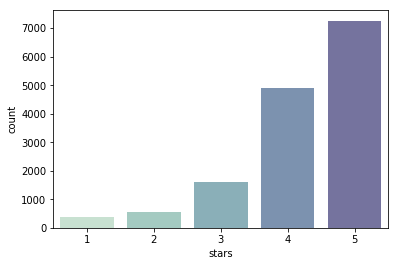

In [3]:
col = sns.color_palette("Blues")
sns.countplot(x=raw_data['stars'], palette = sns.cubehelix_palette(8, start=1, rot=-.75))

In [4]:
variable_types = {'index' : vtypes.Index,
                  'title': vtypes.Text,
                  'text': vtypes.Text,
                  'date': vtypes.Datetime,
                  'price': vtypes.Categorical}

## Step 2. Split Data
In order to avoid label leakage, we want to split the data before performing these operations. So, we will use train test split from the sklearn module to split the data as well as keep the labels for the training and testing (the 'stars' column).

In [5]:
y = raw_data.pop('stars')

X_train, X_test, y_train, y_test = train_test_split(raw_data, y, test_size=0.15, stratify=y)

Now, we will create two different entity sets so that we can create features on each of the sets without leakage.

In [6]:
estrain = ft.EntitySet('Reviews')
estest = ft.EntitySet('Reviews')

estrain = estrain.entity_from_dataframe(entity_id="reviews",
                              dataframe=X_train,
                              index='index',
                              time_index="date",
                              variable_types=variable_types)

estest = estest.entity_from_dataframe(entity_id="reviews",
                              dataframe=X_test,
                              index='index',
                              time_index="date",
                              variable_types=variable_types)

## Step 3. Create Custom Features
Here, we will create custom features so that we can have some Natural Language Processing Features.

First, we will create simple features that focus more on the literal text and the punctuation more than the meaning behind the text.

In [7]:
class TitleCount(TransformPrimitive):
    """Computes the number of title words in a document/string"""
    
    name="title_word_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def title_count(array):
            return [len(re.findall(' [A-Z]|^[A-Z]', i)) for i in array]
        return title_count
    
class PunctuationCount(TransformPrimitive):
    """Computes the number of punctuation marks in a document/string"""
    
    name="punctuation_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def punctuation_count(array):
            punct = set(string.punctuation)
            toks = list(map(word_tokenize, array))
            return [sum(map(lambda x: x in punct, y)) for y in toks]
        return punctuation_count

class StopWordCount(TransformPrimitive):
    """Computes the number of stop words in a document/string"""
    
    name="stop_word_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def stop_words(array):
            swords = set(stopwords.words('english'))
            return [sum(map(lambda x: x in swords, word_tokenize(i))) for i in array]
        return stop_words
    
class CapitalCount(TransformPrimitive):
    """Computes the number of capital letters in a document/string"""
    
    name="capitals_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def capitals(array):
            return [len(re.findall('[A-Z]', i)) for i in array]
        return capitals

class WordCount(TransformPrimitive):
    """Computes the number of words in a document/string"""
    
    name="word_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def word_count(array):
            return [len(word_tokenize(x)) for x in array]
        return word_count

Now, we will create more in depth features, that try to get at the meaning of the text fields. First, we will fit a model based off of the term frequency-inverse document frequency of the training text (and title) data. We will then compose this into a SVD matrix to decrease the number of possible features.

In [8]:
pipeline = make_pipeline(TfidfVectorizer(), TruncatedSVD())

pipeline.fit(X_train['title'].append(X_train['text'], ignore_index=True))

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('truncatedsvd',
                 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
                              random_state=None,

Now, we will create the more complicated features, some of which rely on pre-trained models that are part of packages like nltk or sklearn.

In [9]:
class POS(TransformPrimitive):
    """Computes the number of each of the most common parts of speech used
       in a document/string"""
    
    name="POS_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    number_output_features=15
    
    def get_function(self):
        def pos(array):
            li = [nltk.pos_tag(helpers.clean_tokens(x)) for x in array]
            types = ['C', 'D', 'E', 'F', 'I', 'J',
                     'L', 'M', 'N', 'P', 'R', 'T',
                     'U', 'V', 'W']
            type_arr = []
            for row in li:
                fd = nltk.FreqDist([b[0] for (a,b) in row])
                type_arr.append([fd[i] for i in types])
            return np.array(type_arr).T
        return pos
    
class DiversityScore(TransformPrimitive):
    """Computes the diverity of words used in a document/string"""
    
    name="Diversity"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def diversity(array): 
            ret = []
            for x in array:
                y = helpers.clean_tokens(x)
                if len(y) < 1:
                    ret.append(0)
                else:
                    ret.append(len(set(y))/len(y))           
            return ret
        return diversity
    
class PolarityScore(TransformPrimitive):
    """Computes the percieved positivity(1) or negativity(-1) score of
       a document/string"""
    
    name="Polarity"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def polarity(array):
            vader = SentimentIntensityAnalyzer()
            def vader_pol(sentence):
                return (vader.polarity_scores(sentence)['pos'] - 
                       vader.polarity_scores(sentence)['neg'])
            return [vader_pol(dtk.detokenize(helpers.clean_tokens(x))) for x in array]
        return polarity

class LSA(TransformPrimitive):
    """Computes the latent semantic analysis of a document/string"""
    
    name="LSA"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    number_output_features=2
    
    def get_function(self):
        def lsa(array):
            array = array.apply(lambda x: dtk.detokenize(helpers.clean_tokens(x)))
            return np.array(pipeline.transform(array)).T
        return lsa

class USE(TransformPrimitive):
    """Computes the latent semantic analysis of a document/string"""
    
    name="USE"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    number_output_features=512
    
    def get_function(self):
        def use(array):
            array = array.apply(lambda x: dtk.detokenize(helpers.clean_tokens(x)))
            with tf.Session() as session:
                session.run([tf.global_variables_initializer(), tf.tables_initializer()])
                message_embeddings = session.run(embed(array.tolist()))
            return np.array(message_embeddings).T
        return use

## Step 4. Create Feature Matrices
Here we choose the features we wish to include in the training (in this case all of them), and calculate the training feature matrix. We have set the chunk size to the size of the training set, because the "USE" or Universal Sentence Encoding Feature takes a disproporionately long time to run if calculated in chunks rather than all at once.

In [10]:
trans = [TitleCount, 
         PunctuationCount,
         StopWordCount,
         CapitalCount,
         WordCount, 
         POS,
         DiversityScore,
         PolarityScore,
         LSA,
         USE]

chunk_size_train = estrain['reviews'].shape[0]

train_feature_matrix, features = ft.dfs(entityset=estrain,
                              target_entity='reviews',
                              trans_primitives=trans,
                              verbose=True,
                              chunk_size=chunk_size_train)

Built 21 features
Elapsed: 22:19 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


Now we calculate the features of the test set, using the same chunk size method to optimize runtime for the "USE" primitive.

In [11]:
chunk_size_test = estest['reviews'].shape[0]

test_feature_matrix = ft.calculate_feature_matrix(features=features,
                                                  entityset=estest,
                                                  verbose=True,
                                                  chunk_size=chunk_size_test)

Elapsed: 04:47 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


Here we reindex the test and training feature matrix to ensure that the train and test labels match the indices of the train and test feature matrices

In [12]:
train_feature_matrix = train_feature_matrix.reindex(y_train.index)
test_feature_matrix = test_feature_matrix.reindex(y_test.index)

## Step 5. Machine Learning
Here we create and test various machine learning models from sklearn on the feature matrix.

In [28]:
lgr = LogisticRegression(solver='liblinear', multi_class='auto')
lgr.fit(train_feature_matrix, y_train)
lgr.score(test_feature_matrix, y_test)

0.636734693877551

In [14]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_feature_matrix, y_train)
hgbc.score(test_feature_matrix, y_test)

0.6521541950113379

In [15]:
rfc = RandomForestClassifier(n_estimators=10, class_weight = "balanced", n_jobs=-1)
rfc.fit(train_feature_matrix, y_train)
rfc.score(test_feature_matrix, y_test)

0.5628117913832199

Here we can observe the feature importances for this model, and see that the Universal Sentence Encoder features and the polarity score are the most influential in this model.

In [20]:
headers = ["name", "score"]
values = pd.DataFrame(sorted(zip(train_feature_matrix.columns, rfc.feature_importances_), key=lambda x: x[1] * -1))

values.head(10)

,0,1
0,USE(text)__28,0.014496
1,POLARITY(title),0.012911
2,USE(text)__289,0.012232
3,USE(text)__149,0.011035
4,USE(title)__328,0.010571
5,USE(text)__452,0.007943
6,USE(title)__289,0.007905
7,POLARITY(text),0.007335
8,USE(title)__415,0.006484
9,USE(title)__28,0.006322


In [21]:
bnb = BernoulliNB()
bnb = bnb.fit(train_feature_matrix, y_train)
bnb.score(test_feature_matrix, y_test)

0.4766439909297052

In [ ]:
vot = VotingClassifier(voting='soft', estimators=[('lgr', lgr), ('rfc', rfc), ('hgbc', hgbc)], weights=[3, 1, 6])
vot.fit(train_feature_matrix, y_train)
vot.score(test_feature_matrix, y_test)

So, we can see that the highest score we can get with a model is around 65%, which seems like a pretty poor result. However, given that it is a 5 class classification problem, it is not a horrible score. Furthermore, we can look at the confusion matrix to see where the model goes wrong, and how far off the answer the model is when it is wrong

In [ ]:
helpers.plot_confusion_matrix(y_test, 
                      vot.predict(test_feature_matrix), 
                      ['1', '2', '3', '4', '5'], 
                      normalize=True, 
                      title='Confusion matrix, with normalization')

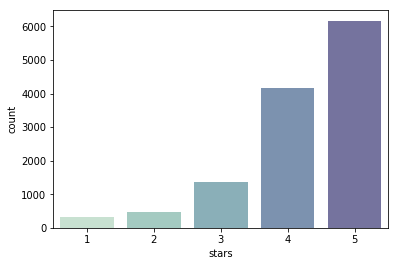

In [24]:
sns.countplot(x=y_train, palette = sns.cubehelix_palette(8, start=1, rot=-.75))

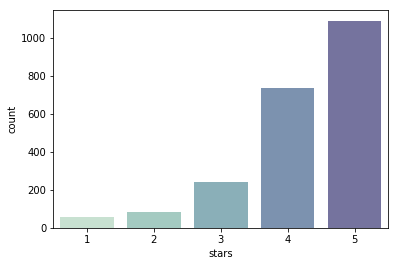

In [25]:
sns.countplot(x=y_test, palette = sns.cubehelix_palette(8, start=1, rot=-.75))

So, from looking at the confusion matrix, it is clear that the model is pretty accurate, and when it predicts the star rating wrong, it is likely within one star of the correct answer, which is much better than a model that has the same accuracy but then predicts the wrong ones as a star rating very wrong on average. Furthermore, as we can see, the predictions have about the same distribution of star ratings as the training data, which suggests that this model is pretty accurate, and doesn't just predict all of the test data to be in the most frequent category.

## 6. Next Steps

While this is an end-to-end example of going from raw text data to a machine learning model with Natural Language Processing Custom Primitives, it is necessary to do before this model would become something impactful. Ideally, in a problem such as this one, there would be more data available, especially pertaining to the customer who wrote each review, that would make the data structure more complicated, but also give the model more insight into patterns of each reviewer, so that it could make more accurate predictions. Luckily, Featuretools makes it easy to deal with relational datasets, and so this new extra data would not be too challenging to incorporate into this model.


<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).